## Part 1 : Can we identify most important features using LOFO ? 
After reading this article(https://towardsdatascience.com/building-an-employee-churn-model-in-python-to-develop-a-strategic-retention-plan-57d5bd882c2d), i was using the same dataset to verify potential added values using more advanced approach.

## Overview:
LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric (source : https://github.com/aerdem4/lofo-importance).
Using LOFO approach provide an appropriate light EDA. Output provide a high level view of features importance in our dataset.


## Related work:
Part 1 : Can we identify most important features using LOFO ? 

Part 2 : What would be the the best traditional modeling approach ? 

Part 3 : Can we predict employee churn uing deep learning ?

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import cross_validate
from tqdm import tqdm_notebook
import multiprocessing
import matplotlib.pyplot as plt # drawing graph
import warnings; warnings.filterwarnings("ignore") 
import os; os.environ['OMP_NUM_THREADS'] = '4' # speed up using 4 cpu

In [2]:
def infer_model(df, features, target, n_jobs):
    model_class = LGBMRegressor
    if len(df[target].value_counts()) == 2:
        df[target] = LabelEncoder().fit_transform(df[target])
        model_class = LGBMClassifier

    categoricals = []
    for f in features:
        if df[f].dtype == object:
            df[f] = LabelEncoder().fit_transform(df[f].apply(str))
            categoricals.append(f)

    min_child_samples = int(0.01*df.shape[0])

    model = model_class(min_child_samples=min_child_samples, n_jobs=n_jobs)

    return model, df, categoricals

In [3]:
class LOFOImportance:

    def __init__(self, df, features, target,
                 scoring, model=None, cv=4, n_jobs=None):

        df = df.copy()
        self.fit_params = {}
        if model is None:
            model, df, categoricals = infer_model(df, features, target, n_jobs)
            self.fit_params["categorical_feature"] = categoricals
            n_jobs = 1

        self.model = model
        self.df = df
        self.features = features
        self.target = target
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs
        if self.n_jobs is not None and self.n_jobs > 1:
            warning_str = "Warning: If your model is multithreaded, please initialise the number \
                of jobs of LOFO to be equal to 1, otherwise you may experience issues."
            warnings.warn(warning_str)

    def _get_cv_score(self, X, y):
        fit_params = self.fit_params.copy()
        if "categorical_feature" in self.fit_params:
            fit_params["categorical_feature"] = [cat for cat in fit_params["categorical_feature"] if cat in X.columns]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(self.model, X, y, cv=self.cv, scoring=self.scoring, fit_params=fit_params)
        return cv_results['test_score']

    def _get_cv_score_parallel(self, feature, feature_list, result_queue, base=False):
        test_score = self._get_cv_score(self.df[feature_list], self.df[self.target])
        if not base:
            result_queue.put((feature, test_score))
        return test_score

    def get_importance(self):
        base_cv_score = self._get_cv_score(self.df[self.features], self.df[self.target])

        if self.n_jobs is not None and self.n_jobs > 1:
            pool = multiprocessing.Pool(self.n_jobs)
            manager = multiprocessing.Manager()
            result_queue = manager.Queue()

            base_cv_score = self._get_cv_score_parallel('all', self.features, result_queue, True)
            for f in self.features:
                feature_list = [feature for feature in self.features if feature != f]
                pool.apply_async(self._get_cv_score_parallel, (f, feature_list, result_queue))

            pool.close()
            pool.join()

            lofo_cv_scores = [result_queue.get() for _ in range(len(self.features))]
            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score
                                                  for f, lofo_cv_score in lofo_cv_scores])
            self.features = [score[0] for score in lofo_cv_scores]
        else:
            lofo_cv_scores = []
            for f in tqdm_notebook(self.features):
                feature_list = [feature for feature in self.features if feature != f]
                lofo_cv_scores.append(self._get_cv_score(self.df[feature_list], self.df[self.target]))

            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score for lofo_cv_score in lofo_cv_scores])

        importance_df = pd.DataFrame()
        importance_df["feature"] = self.features
        importance_df["importance_mean"] = lofo_cv_scores_normalized.mean(axis=1)
        importance_df["importance_std"] = lofo_cv_scores_normalized.std(axis=1)

        return importance_df.sort_values("importance_mean", ascending=False)


def plot_importance(importance_df, figsize=(8, 8)):
    importance_df = importance_df.copy()
    importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
    importance_df.sort_values("importance_mean", inplace=True)

    importance_df.plot(x="feature", y="importance_mean", xerr="importance_std",
                       kind='barh', color=importance_df["color"], figsize=figsize)

In [4]:
dtypes={
    'Age':                         'int64',
    'Attrition':                   'category',
    'BusinessTravel':              'category',
    'DailyRate':                   'int64',
    'Department':                  'category',
    'DistanceFromHome':            'int64',
    'Education':                   'int64',
    'EducationField':              'category',
    'EmployeeCount':               'int64',
    'EmployeeNumber':              'int64',
    'EnvironmentSatisfaction':     'int64',
    'Gender':                      'category',
    'HourlyRate':                  'int64',
    'JobInvolvement':              'int64',
    'JobLevel':                    'int64',
    'JobRole':                     'category',
    'JobSatisfaction':             'int64',
    'MaritalStatus':               'category',
    'MonthlyIncome':               'int64',
    'MonthlyRate':                 'int64',
    'NumCompaniesWorked':          'int64',
    'Over18':                      'category',
    'OverTime':                    'category',
    'PercentSalaryHike':           'int64',
    'PerformanceRating':           'int64',
    'RelationshipSatisfaction':    'int64',
    'StandardHours':               'int64',
    'StockOptionLevel':            'int64',
    'TotalWorkingYears':           'int64',
    'TrainingTimesLastYear':       'int64',
    'WorkLifeBalance':             'int64',
    'YearsAtCompany':              'int64',
    'YearsInCurrentRole':          'int64',
    'YearsSinceLastPromotion':     'int64',
    'YearsWithCurrManager':        'int64',}

In [5]:
# source : https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
df = pd.read_excel('../input/WA_Fn-UseC_-HR-Employee-Attrition.xlsx', sheet_name=0,dtype=dtypes)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (1470, 35)


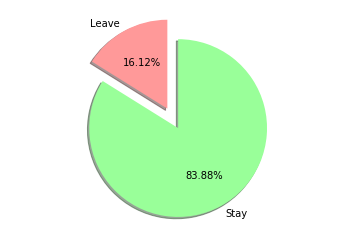

In [6]:
# Cheese view of target data
labels = 'Leave', 'Stay'
colors = ['#ff9999','#99ff99']
sizes = [df['Attrition'].value_counts()['Yes'],df['Attrition'].value_counts()['No']]
explode = (0.25, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [7]:
sample_df = df.sample(frac=1, random_state=0)
sample_df.sort_values("EmployeeNumber", inplace=True)

cv = KFold(n_splits=4, shuffle=False, random_state=0)
target = "Attrition"
features = [col for col in df.columns if col != target]

lofo = LOFOImportance(sample_df, features, target, cv=cv, scoring="roc_auc")
importance_df= lofo.get_importance()

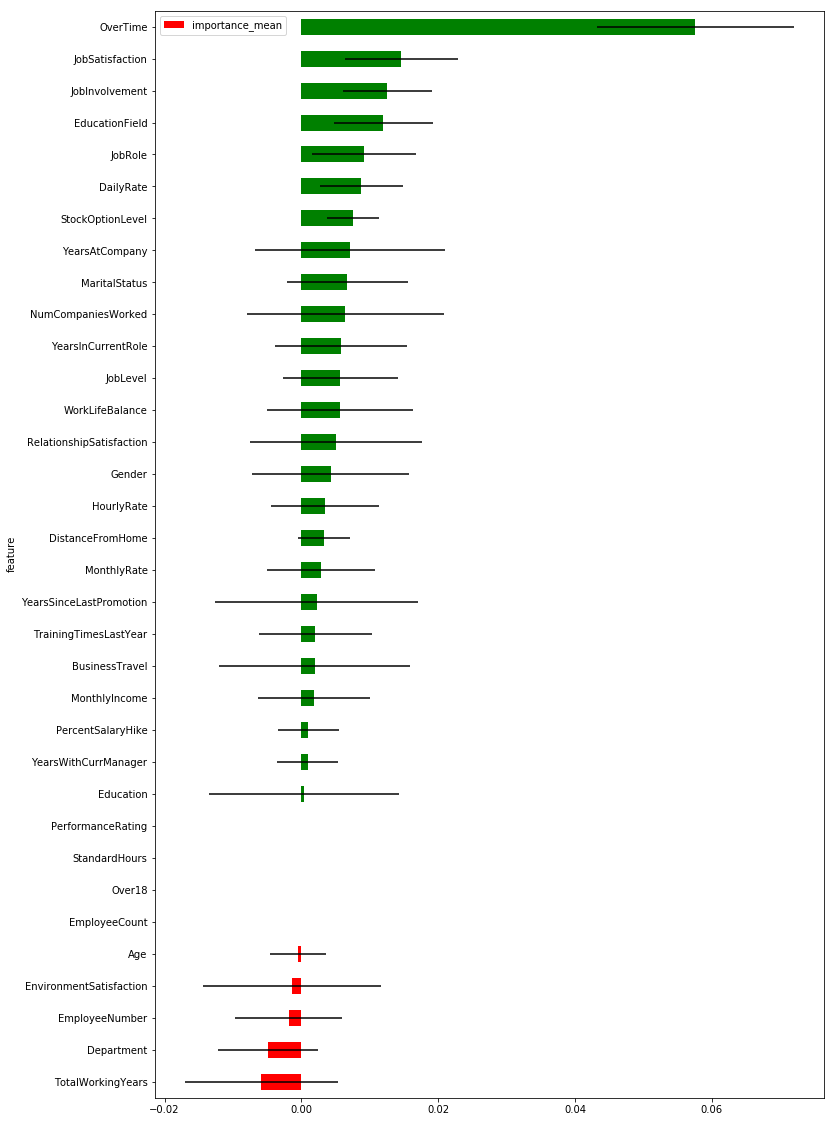

In [8]:
plot_importance(importance_df, figsize=(12, 20))